In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn

import safetensors
from accelerate import notebook_launcher

import einops

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, simple_train_model

from models.vq_brain import SoundStream
from transformers import GPT2Tokenizer
from models.simple_mae import SimpleEncoder, SimpleMAE
from dataclasses import dataclass
from simple_parsing.helpers import Serializable


In [2]:
@dataclass
class SimpleEncoderConfig(Serializable):
    # data params
    block_size: int = 768
    patch_size: int = 256

    n_layers: int = 8
    dim: int = 512
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 16
    n_kv_heads: int = 16 # now it should be the same with n_heads.
    rope_theta: int = 10000

@dataclass
class SimpleMAEConfig(Serializable):
    # data params
    n_layers: int = 4
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8 # now it should be the same with n_heads.
    rope_theta: int = 10000


In [3]:
config_encoder = SimpleEncoderConfig()
config_mae = SimpleMAEConfig()

encoder = SimpleEncoder(config_encoder)
model = SimpleMAE(config_encoder, config_mae)

Encoder: number of parameters: 21.11M
Shape of the rope cache:  torch.Size([768, 16])
Encoder: number of parameters: 21.11M
Shape of the rope cache:  torch.Size([768, 16])
MAE: number of parameters: 25.70M


### Run training pipeline

In [ ]:
project_name = 'simple_mae'

train_config = TrainConfig(exp_name='mae_v2_21M_5M',
                           mixed_precision=True,
                           batch_size=256, 
                           num_workers=3,
                           pin_memory=True, 
                           eval_interval=1000, 
                           learning_rate=3e-4,
                           weight_decay=0, 
                           grad_clip=5, 
                           lr_decay_iters=30_000, 
                           warmup_iters=500
                          )
# peter path
# data_path = Path(r'C:\Users\peter\alvi\brain2text\competitionData')

# data_path = Path(r'D:\Work\brain-to-text-competition\data\competitionData')

data_path = Path("/drive/data/competitionData")
save_folder = Path("/drive/logs/kovalev")

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

train_dataset = BrainDataset(data_path / 'train', tokenize_function=get_tokenizer(tokenizer), max_input_len=768)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), max_input_len=768)

# indices = torch.arange(1).repeat(128)
# train_dataset = torch.utils.data.Subset(test_dataset, indices)
# test_dataset = torch.utils.data.Subset(test_dataset, indices)

model = torch.compile(model)
args = (model, (train_dataset, test_dataset), train_config, project_name, save_folder)
notebook_launcher(run_train_model, args, num_processes=1)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Runed processing of the  /drive/data/competitionData/train
len: 8800
max input len 768
Runed processing of the  /drive/data/competitionData/test
len: 880
max input len 768
Launching training on one GPU.


/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
wandb: Currently logged in as: koval_alvi. Use `wandb login --relogin` to force relogin


Device for training:  cuda
Num devices:  1
Completed initialization of scheduler


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_inductor/lowering.py:1611: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [10]:
save_folder = Path("/drive/logs/kovalev")

safetensors.torch.save_model(model, save_folder / 'model_mae_long_train.safetensors')

In [ ]:
model

In [12]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [18]:
model = model._orig_mod

tensor(0.5542)


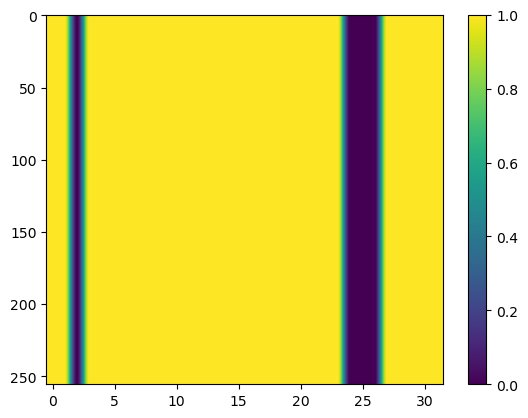

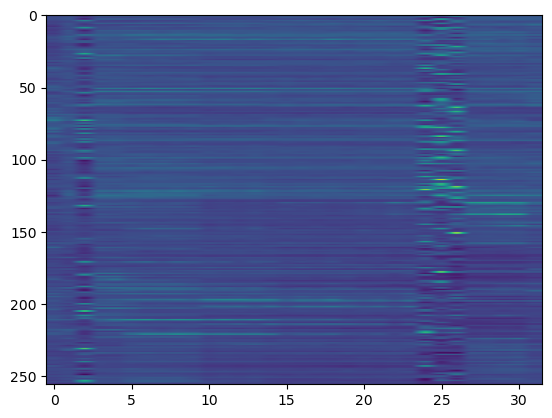

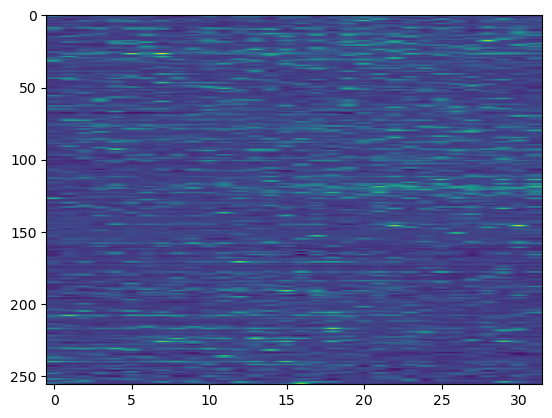

In [90]:
x = train_dataset[0][0]

x = torch.from_numpy(x[None, :]).to('cuda')

loss, y, binary = model(x, masking_ratio=0.9,  return_preds=True)

x = x.detach().cpu()[0]
y = y.detach().cpu()[0]
binary = binary.detach().cpu()[0]

import matplotlib.pyplot as plt 

# plt.plot(y[1, :])
# plt.show()
# plt.plot(x[1, :])
# plt.show()
loss = F.l1_loss(y, x, reduction='none')
print(torch.mean(loss[loss>0]))

plt.show()
plt.imshow(binary[32:64].T, aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(y[32:64].T, aspect='auto')
plt.show()
plt.imshow(x[32:64].T, aspect='auto')

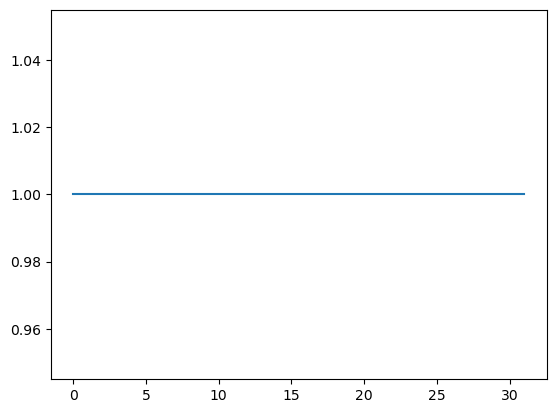

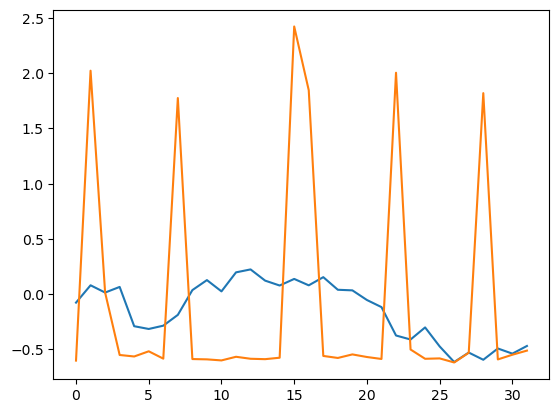

In [91]:
plt.show()
plt.plot(binary[:32, 10])
plt.show()
plt.plot(y[:32, 10])
# plt.show()
plt.plot(x[:32, 10])